In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sqlalchemy import create_engine

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
  postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

#### Feature Exploration:

In [3]:
houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [4]:
# drop all columns that contain null values (there are better ways to deal with nulls, but this is fastest for now)
houseprices.drop('id', axis=1, inplace=True)
cols = houseprices.columns
for col in cols:
    if (houseprices[col].isnull().sum() * 100)/len(houseprices) > 0:
        houseprices.drop(col, axis=1, inplace=True)
cols = houseprices.columns
print(len(houseprices.columns))

61


In [5]:
numeric_list = []
for col in cols:
    if (houseprices[col].dtypes == np.int64) or (houseprices[col].dtypes == np.float64):
        numeric_list.append(col)
print(numeric_list)

['mssubclass', 'lotarea', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice']


In [6]:
num_df = houseprices[numeric_list]
num_df.head()

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,60,8450,7,5,2003,2003,706,0,150,856,...,0,61,0,0,0,0,0,2,2008,208500
1,20,9600,6,8,1976,1976,978,0,284,1262,...,298,0,0,0,0,0,0,5,2007,181500
2,60,11250,7,5,2001,2002,486,0,434,920,...,0,42,0,0,0,0,0,9,2008,223500
3,70,9550,7,5,1915,1970,216,0,540,756,...,0,35,272,0,0,0,0,2,2006,140000
4,60,14260,8,5,2000,2000,655,0,490,1145,...,192,84,0,0,0,0,0,12,2008,250000


In [7]:
# Move target column to front
y = houseprices['saleprice']
num_df.drop('saleprice', axis=1, inplace=True)
num_df.insert(0, 'saleprice', y)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


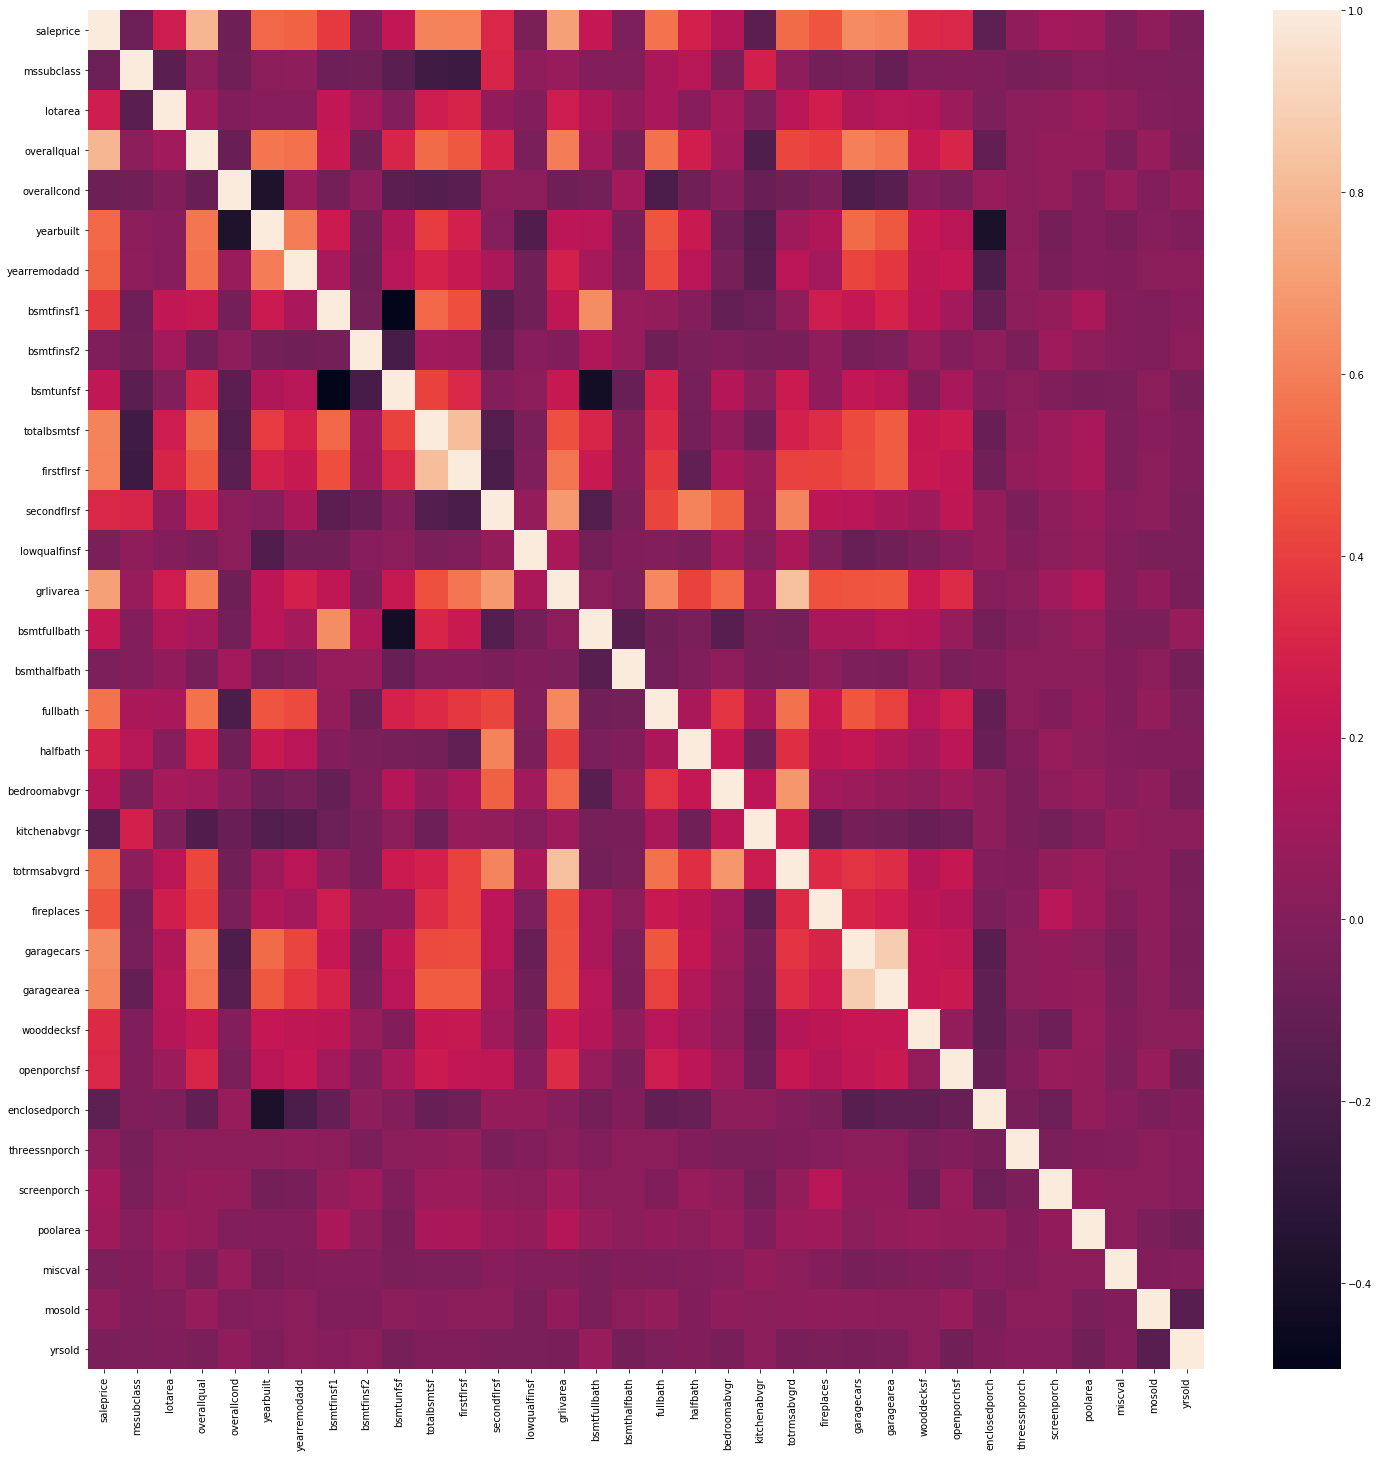

In [8]:
fig = plt.subplots(figsize=(25,25))
num_corr = num_df.corr()
sns.heatmap(num_corr)

In [9]:
# Populate list with all numeric columns and remove any that are too closely correlated

features = list(num_corr.columns)
print('original feature length: {}'.format(len(features)))

# Loops to check correlation under diagonal (where columns correlate with themselves)
for x in range(0, len(num_corr.columns), 1):
    col =  abs(num_corr.iloc[(x+1):, x]).sort_values(ascending=False)
    for y in range(len(col)):
        if col[y] > .700:
            if col.index[y] in features:
                features.remove(col.index[y])
#if 'saleprice' not in features:
#    features.append('saleprice')
print('new feature length: {}'.format(len(features)))

original feature length: 34
new feature length: 29


In [10]:
# test cell
col = abs(num_corr.iloc[3:, 2]).sort_values(ascending=False)
col.index[0]

'firstflrsf'

In [11]:
num_df = num_df[features]

In [12]:
num_df.head()

,saleprice,mssubclass,lotarea,overallcond,yearbuilt,yearremodadd,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagecars,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold
0,208500,60,8450,5,2003,2003,706,0,150,856,...,2,0,61,0,0,0,0,0,2,2008
1,181500,20,9600,8,1976,1976,978,0,284,1262,...,2,298,0,0,0,0,0,0,5,2007
2,223500,60,11250,5,2001,2002,486,0,434,920,...,2,0,42,0,0,0,0,0,9,2008
3,140000,70,9550,5,1915,1970,216,0,540,756,...,3,0,35,272,0,0,0,0,2,2006
4,250000,60,14260,5,2000,2000,655,0,490,1145,...,3,192,84,0,0,0,0,0,12,2008


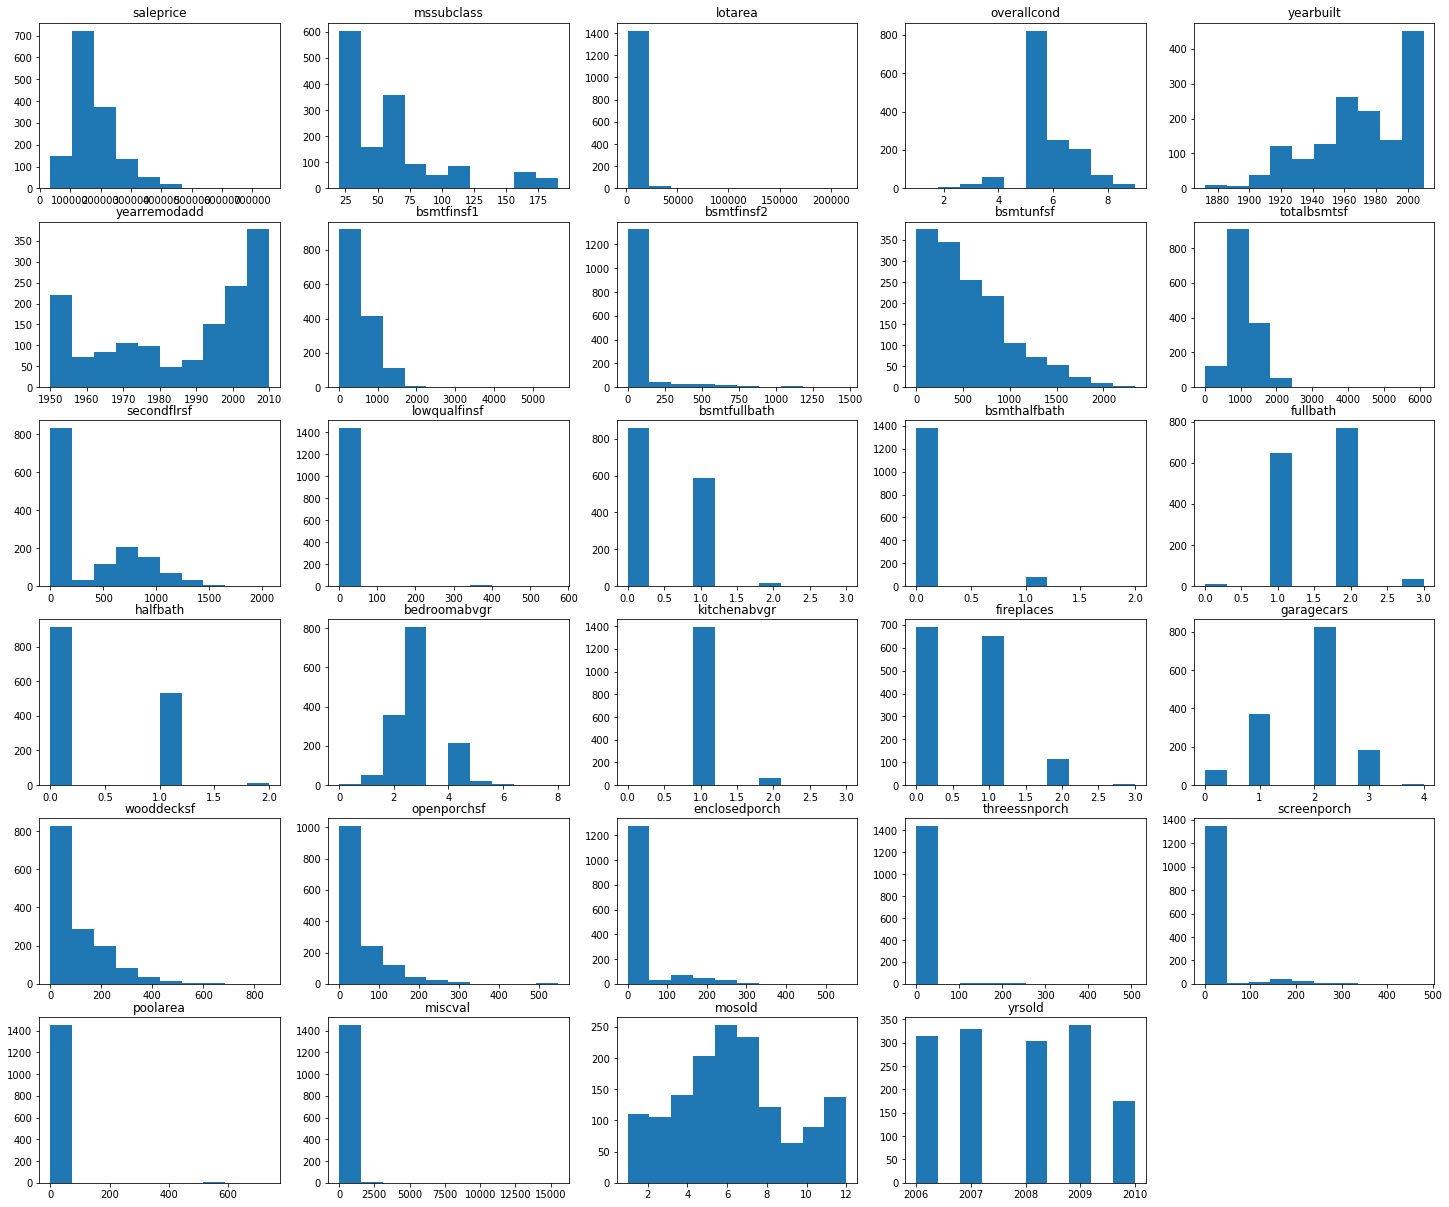

In [13]:
# Univariate analysis with histograms
fig = plt.subplots(figsize=(25,25))
for x in range(len(num_df.columns)):
    plt.subplot(7, 5, x+1)
    plt.hist(num_df.iloc[:, x])
    plt.title('{}'.format(num_df.iloc[:, x].name))

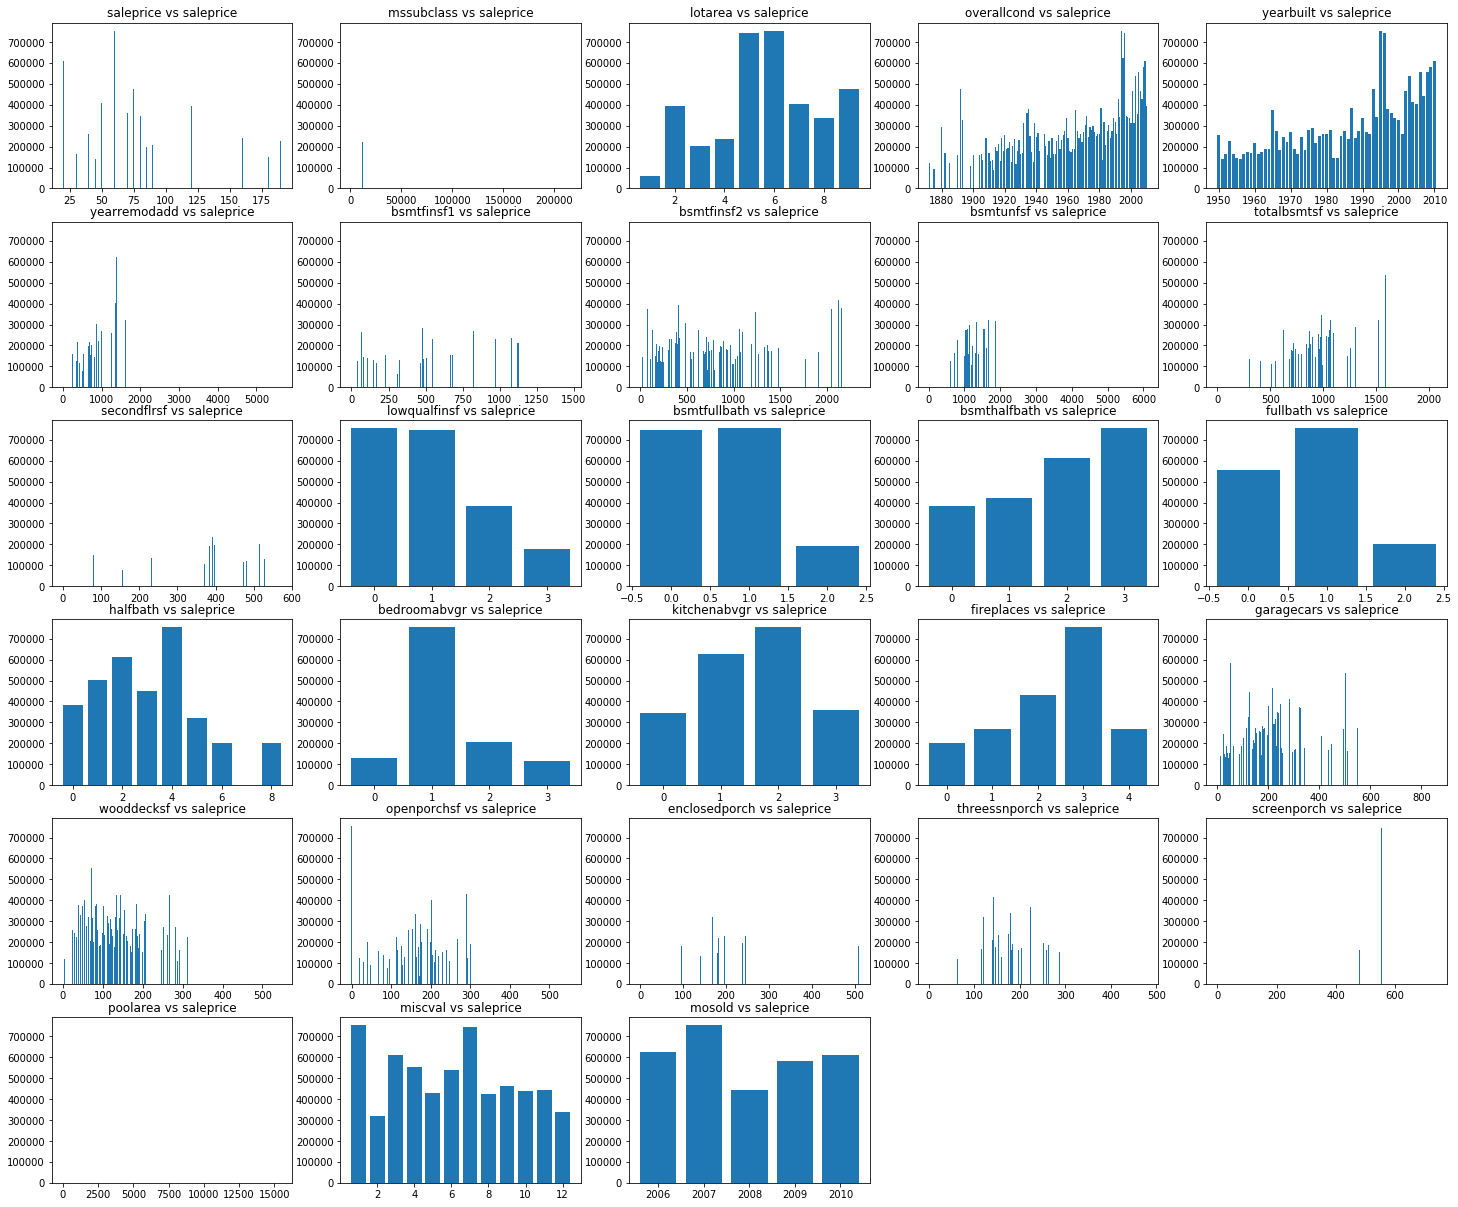

In [14]:
# multivariate analysis with bar graphs; numeric values
fig = plt.subplots(figsize=(25,25))

not_saleprice = num_df.drop('saleprice', axis=1)
for x in range(len(not_saleprice.columns)):
    plt.subplot(7, 5, x+1)
    plt.bar(not_saleprice.iloc[:, x], num_df['saleprice'])
    plt.title('{} vs saleprice'.format(num_df.iloc[:, x].name))

In [15]:
# Make list of non-numeric columns
nonum_list = []
for col in cols:
    if col not in num_corr.columns: # num_corr chosen because it contains all numeric value columns
        nonum_list.append(col)
        
print(nonum_list)

['mszoning', 'street', 'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'exterqual', 'extercond', 'foundation', 'heating', 'heatingqc', 'centralair', 'kitchenqual', 'functional', 'paveddrive', 'saletype', 'salecondition']


In [16]:
nonum_df = houseprices[nonum_list]
nonum_df.head()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,extercond,foundation,heating,heatingqc,centralair,kitchenqual,functional,paveddrive,saletype,salecondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,TA,BrkTil,GasA,Gd,Y,Gd,Typ,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal


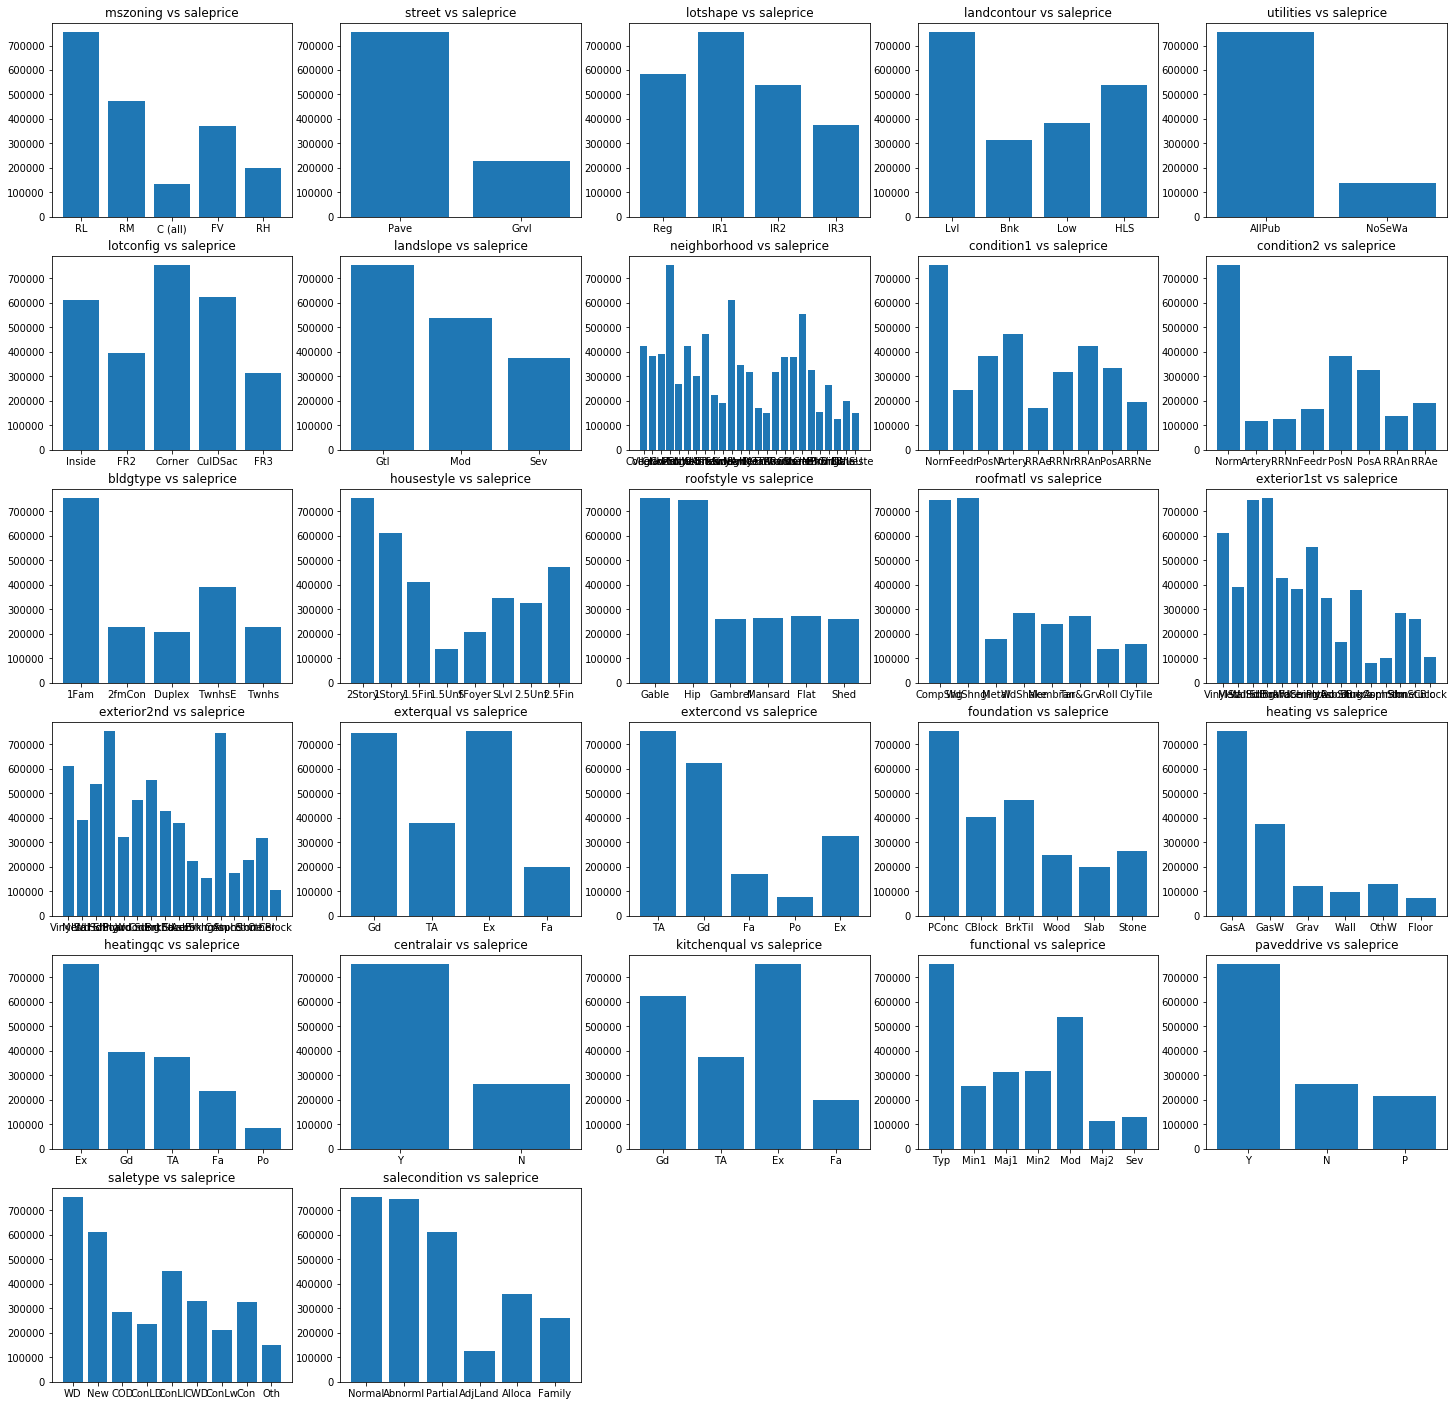

In [17]:
# multivariate analysis with bar graphs; non-numeric values
fig = plt.subplots(figsize=(25,25))
for x in range(len(nonum_df.columns)):
    plt.subplot(6, 5, x+1)
    plt.bar(nonum_df.iloc[:, x], num_df['saleprice'])
    plt.title('{} vs saleprice'.format(nonum_df.iloc[:, x].name))

##### Feature Selection:

In [18]:
new_corr = num_df.corr()

In [19]:
# add numeric columns to feats list
feats_list = []
sale = abs(new_corr.loc[:, 'saleprice']).sort_values(ascending=False)
for x in new_corr.columns:
    if x != 'saleprice':
        if sale[x] > .5000:
            feats_list.append(x)
print(feats_list)

# numeric features can be scaled or normalized to fit the algorithms better

['yearbuilt', 'yearremodadd', 'totalbsmtsf', 'fullbath', 'garagecars']


In [20]:
# add non-numeric columns to feats list
for x in nonum_df.columns:
    if len(nonum_df[x].unique()) < 5:
        feats_list.append(x)
print(feats_list)

['yearbuilt', 'yearremodadd', 'totalbsmtsf', 'fullbath', 'garagecars', 'street', 'lotshape', 'landcontour', 'utilities', 'landslope', 'exterqual', 'centralair', 'kitchenqual', 'paveddrive']


In [21]:
# turn all non-numeric categories into dummy columns
feats_df = houseprices[feats_list]
for col in feats_df.columns:
    if col in nonum_df.columns:
        dum_df = pd.get_dummies(feats_df[col], prefix= col, drop_first=True)
        feats_df = pd.concat([feats_df, dum_df], axis=1)
        feats_df.drop(col, axis=1, inplace=True)
     

In [22]:
feats_df.columns

Index(['yearbuilt', 'yearremodadd', 'totalbsmtsf', 'fullbath', 'garagecars',
       'street_Pave', 'lotshape_IR2', 'lotshape_IR3', 'lotshape_Reg',
       'landcontour_HLS', 'landcontour_Low', 'landcontour_Lvl',
       'utilities_NoSeWa', 'landslope_Mod', 'landslope_Sev', 'exterqual_Fa',
       'exterqual_Gd', 'exterqual_TA', 'centralair_Y', 'kitchenqual_Fa',
       'kitchenqual_Gd', 'kitchenqual_TA', 'paveddrive_P', 'paveddrive_Y'],
      dtype='object')

In [23]:
# Fit with ordinary least squares method
y = houseprices.saleprice
X = feats_df
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     157.2
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        05:57:59   Log-Likelihood:                -17603.
No. Observations:                1460   AIC:                         3.526e+04
Df Residuals:                    1435   BIC:                         3.539e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4.299e+04   1.69e+05     -0.255      0.799   -3.74e+05    2.88e+05
yearbuilt         -118.5391     58.280     -2.034      0.042    -232.862      -4.216
yearremodadd       199.8212     78.737      2.538      0.011      45.370     354.273
totalbsmtsf         42.3330      3.091     13.696      0.000      36.270      48.396
fullbath          2.863e+04   2501.205     11.446      0.000    2.37e+04    3.35e+04
garagecars        2.431e+04   1963.661     12.380      0.000    2.05e+04    2.82e+04
street_Pave       2.598e+04   1.86e+04      1.398      0.162   -1.05e+04    6.24e+04
lotshape_IR2      1.087e+04   6961.795      1.562      0.118   -2781.618    2.45e+04
lotshape_IR3     -2.905e+04   1.37e+04     -2.119      0.034    -5.6e+04   -2154.566
lotshape_Reg     -1.117e+04   2473.442     -4.517      0.000    -1.6e+04   -6319.387
landcontour_HLS   2.079e+04   8200.993      2.535      0.011    4699.323    3.69e+04
landcontour_Low   1.308e+04   9791.857      1.336      0.182   -6124.240    3.23e+04
landcontour_Lvl   8405.1383   5862.460      1.434      0.152   -3094.771    1.99e+04
utilities_NoSeWa -1.846e+04   4.23e+04     -0.436      0.663   -1.01e+05    6.45e+04
landslope_Mod     1.906e+04   6416.891      2.970      0.003    6469.930    3.16e+04
landslope_Sev     2.789e+04   1.35e+04      2.064      0.039    1387.455    5.44e+04
exterqual_Fa     -8.072e+04   1.55e+04     -5.221      0.000   -1.11e+05   -5.04e+04
exterqual_Gd     -4.845e+04   7387.912     -6.557      0.000   -6.29e+04    -3.4e+04
exterqual_TA     -7.155e+04   8093.002     -8.841      0.000   -8.74e+04   -5.57e+04
centralair_Y      1.716e+04   5195.210      3.303      0.001    6970.243    2.74e+04
kitchenqual_Fa   -6.415e+04   9828.232     -6.527      0.000   -8.34e+04   -4.49e+04
kitchenqual_Gd   -5.797e+04   5507.776    -10.524      0.000   -6.88e+04   -4.72e+04
kitchenqual_TA   -7.024e+04   6213.382    -11.305      0.000   -8.24e+04   -5.81e+04
paveddrive_P      7963.5797   9068.714      0.878      0.380   -9825.778    2.58e+04
paveddrive_Y      5840.9337   5306.885      1.101      0.271   -4569.151    1.63e+04
==============================================================================
Omnibus:                      476.496   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11059.088
Skew:                           0.967   Prob(JB):                         0.00
Kurtosis:                      16.344   Cond. No.                     4.59e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.59e+05. This might indicate that there are
strong multicollinearity or other numerical pr